# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob
from tqdm import tqdm
import pandas as pd

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
import os

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from workspace_utils import active_session


import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline

In [2]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


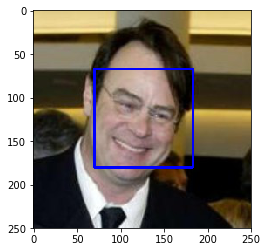

In [3]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
- Thankfully, in the short human images dataset, almost all images (98%) were detected as containing humans. This is good news.
- Unfortunately, the `face_detector` function has incorrectly detected humans (17%) in the dog images dataset. Apparently, our hammer sees everything as a nail.

In [5]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]
#-#-# Do NOT modify the code above this line. #-#-#

In [6]:
## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

In [7]:
detected_humans_in_human_images = []
for human_img in human_files_short:
    detected_humans_in_human_images.append(face_detector(human_img))

In [8]:
pd.Series(detected_humans_in_human_images).value_counts()

True     98
False     2
dtype: int64

In [9]:
detected_humans_in_dog_images = []
for dog_img in dog_files_short:
    detected_humans_in_dog_images.append(face_detector(dog_img))

In [10]:
pd.Series(detected_humans_in_dog_images).value_counts()

False    83
True     17
dtype: int64

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [11]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 86114775.86it/s]


In [12]:
print(VGG16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [13]:
test_transforms = transforms.Compose([
                                        transforms.Resize(266),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                    ])

In [14]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    img_pil = Image.open(img_path)
    test_tensor = test_transforms(img_pil)
    ## Return the *index* of the predicted class for that image
    test_tensor = test_tensor.unsqueeze(0)
    test_output = VGG16(test_tensor)
    test_top_p,test_top_classes = test_output.topk(1,dim=1)
    prediced_class_index = test_top_classes[0][0]

    
    return prediced_class_index # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [15]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    predicted_class_index = VGG16_predict(img_path)
    predicted_class_index = int(predicted_class_index)
    dog_detected = ((predicted_class_index>=151) & (predicted_class_index<=268))
    return dog_detected # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
- We can see that only 1% in the human images dataset were detected as containing dogs. This is a good level of performance.
- Moreover, 100% of the images from the dogs image dataset were detected as containing dogs. This is also awesome.

In [16]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

In [17]:
dogs_in_human_images = []
for human_image in human_files_short:
    dogs_in_human_images.append(dog_detector(human_image))

In [18]:
pd.Series(dogs_in_human_images).value_counts()

False    99
True      1
dtype: int64

In [19]:
dogs_in_dog_images = []
for dog_image in dog_files_short:
    dogs_in_dog_images.append(dog_detector(dog_image))

In [20]:
pd.Series(dogs_in_dog_images).value_counts()

True    100
dtype: int64

We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [21]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes


In [22]:
data_dir = '/data/dog_images'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [23]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([
                                        transforms.RandomRotation(30),
                                        transforms.RandomResizedCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                    ])
test_transforms = transforms.Compose([
                                        transforms.Resize(266),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                    ])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir,transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir,transform=test_transforms)
test_data = datasets.ImageFolder(test_dir,transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=64)

In [24]:
loaders = {}
loaders['train'] = train_loader
loaders['valid'] = valid_loader
loaders['test'] = test_loader

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
- The target size for all input images is 224x224 pixels. This target size is needed as it's the accepted input size for the VGG16 network.
    - For the training dataset, images are resized to 224x224 and randomly cropped in order to introduce more variance in the dataset that will eventually increase the size of the dataset and prevent the model from overfitting.
    - For the testing and validation datasets, images are initially resized to 266. Then, images are cropped at the center with the 224x224 size.
- In terms of augmentations, the training dataset has been augemented as follows:
    - Initially, images are randomly rotated by 30 degrees.
    - Then, images are randomly resized then cropped to 224x224 size
    - After that, images are randomly flipped on the horizontal axis.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [25]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=2,padding=1)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.2)
        
        self.fc1 = nn.Linear(7*7*128, 500)
        self.fc2 = nn.Linear(500, 133)
        self.logsoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        ## Define forward behavior
        x = self.conv1(x)
        x = self.pool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.relu(x)
        
        
        #print(x.shape)
        x = x.view(-1, 7*7*128)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.logsoftmax(x)
        
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [26]:
print(model_scratch)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace)
  (dropout): Dropout(p=0.2)
  (fc1): Linear(in_features=6272, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (logsoftmax): LogSoftmax()
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

The architecture for my "from scratch" model is designed as follows:

- Conv1: In order to extract features from the input image, I passed the input to a Convolutional layer that generates 32 filters. This layer will also reduce the dimension of the data by shrinking the input size to 112x112 pixels.
    - input size `[Batch,3,224,224]`, output size `[Batch,32,112,112]`
- ReLU: ReLU activation before passing the output to the next layer.
- pool: Pool layer with stride = 2 to reduce the input size to half
    - input size `[Batch,32,112,112]`, output size `[Batch,32,56,56]`
- Conv2: Further filtering of features with a deeper convolutional layer and further reduction of input size.
    - input size `[Batch,32,56,56]`, output size `[Batch,64,28,28]`
- ReLU: ReLU activation before passing the output to the next layer.
- pool: Pool layer with stride = 2 to reduce the input size to half
    - input size `[Batch,64,28,28]`, output size `[Batch,64,14,14]`
- Conv3: Further filtering of features with a deeper convolutional layer of 128 filters. This layer will also not reduce the data size and will keep the dimensions to 14x14.
    - input size `[Batch,64,14,14]`, output size `[Batch,128,14,14]`
- ReLU: ReLU activation before passing the output to the next layer.
- pool: Pool layer with stride = 2 to reduce the input size to half
    - input size `[Batch,128,14,14]`, output size `[Batch,128,7,7]`
- Output reshaping: Reshaping the data to the required dimensions for the following Fully-Connected layers
    - input size `[Batch,128,7,7]`, output size `[Batch,128*7*7]`
- fc1: A fully connected layer that reads the availabe complex feature extracts from the previous convolutional layers to construct a classification logic for the dog breed classification task.
- ReLU: ReLU activation before passing the output to the next layer.
- Dropout: A dropout layer with a 20% probability that helps reduce the risk of overfitting by forcing the network to train on subsets of the perceptrons.
- fc2: Another fully-connected layer to increase the complexity of the prediction logic.
- ReLU: ReLU activation before passing the output to the next layer.
- Dropout: A dropout layer with a 20% probability that helps reduce the risk of overfitting by forcing the network to train on subsets of the perceptrons.
- Logsoftmax: A final layer of LogSoftmax logic to re-scale the class scores to meaningful probabilities across the classes


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [27]:
### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(),lr=0.05)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [28]:
def get_accuracy(logps,labels):
    temp_logps = logps
    temp_labels = labels
    ps = torch.exp(logps)
    top_p,top_class = ps.topk(1,dim=1)
    equals = top_class == labels.view(*top_class.shape)
    batch_accuracy = torch.mean(equals.type(torch.FloatTensor)).item()
    return batch_accuracy

In [29]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        valid_accuracy = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
            
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output,target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            accuracy_score = get_accuracy(output,target)
            valid_accuracy = valid_accuracy + ((1 / (batch_idx + 1)) * (accuracy_score - valid_accuracy))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            valid_accuracy
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [30]:
n_epochs = 100

In [46]:
# train the model
with active_session():
    model_scratch = train(n_epochs, loaders, model_scratch, optimizer_scratch,criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.887489 	Validation Loss: 4.879744 	Validation Accuracy: 0.013393
Validation loss decreased (inf --> 4.879744).  Saving model ...
Epoch: 2 	Training Loss: 4.877090 	Validation Loss: 4.867045 	Validation Accuracy: 0.020089
Validation loss decreased (4.879744 --> 4.867045).  Saving model ...
Epoch: 3 	Training Loss: 4.864762 	Validation Loss: 4.842531 	Validation Accuracy: 0.024554
Validation loss decreased (4.867045 --> 4.842531).  Saving model ...
Epoch: 4 	Training Loss: 4.849305 	Validation Loss: 4.821650 	Validation Accuracy: 0.017857
Validation loss decreased (4.842531 --> 4.821650).  Saving model ...
Epoch: 5 	Training Loss: 4.831624 	Validation Loss: 4.798123 	Validation Accuracy: 0.026786
Validation loss decreased (4.821650 --> 4.798123).  Saving model ...
Epoch: 6 	Training Loss: 4.816185 	Validation Loss: 4.772132 	Validation Accuracy: 0.025670
Validation loss decreased (4.798123 --> 4.772132).  Saving model ...
Epoch: 7 	Training Loss: 4.803530 	Vali

In [31]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt',map_location={'cuda:0': 'cpu'}))
#model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [32]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [50]:
# call test function    
test(loaders, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.555511


Test Accuracy: 18% (157/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [33]:
## Same dataloader from the previous step will be used.

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [34]:
def set_target_model():
    # create a dense net model
    model = models.vgg16(pretrained = True)

    # switch off the gradients of the convolutional feature recognition layer
    for param in model.parameters():
        param.requires_grad = False # this will stop training for the vgg16 pre-trained network
    
    
    # replace the classifier layer
    # parameters here require gradient by default
    model.classifier = nn.Sequential(
        nn.Linear(25088,750),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(750,300),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(300,133),
        nn.LogSoftmax(dim=1)
    )
    return model

In [35]:
## TODO: Specify model architecture 
model_transfer = set_target_model()

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__

- For feature recongnition, I decided to use a pretrained VGG16 network. Only the convolutionl layers of this network will be kept for the sake of pattern recognition. Furthermore, all training parameters for these convolutional layers have been switched off such that it does get trained.
- Three Fully-connected layers with ReLU acitivation and dropout rate of 20% have been added on top of the VGG16 pretrained network. These will be trained to the use the features recognized by the VGG16 layer in order to build a logic for the classification of the 133 dog breeds.
- The final output of the model will pass through a LogSoftmax activation in order to re-scale the class scores to a meaningful probability distribution.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [36]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(),lr=0.005)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [55]:
# train the model
model_transfer = train(40, loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 4.761965 	Validation Loss: 4.362102 	Validation Accuracy: 0.170759
Validation loss decreased (inf --> 4.362102).  Saving model ...
Epoch: 2 	Training Loss: 4.242855 	Validation Loss: 3.333441 	Validation Accuracy: 0.349330
Validation loss decreased (4.362102 --> 3.333441).  Saving model ...
Epoch: 3 	Training Loss: 3.489644 	Validation Loss: 2.258886 	Validation Accuracy: 0.493304
Validation loss decreased (3.333441 --> 2.258886).  Saving model ...
Epoch: 4 	Training Loss: 2.855810 	Validation Loss: 1.578775 	Validation Accuracy: 0.627976
Validation loss decreased (2.258886 --> 1.578775).  Saving model ...
Epoch: 5 	Training Loss: 2.410823 	Validation Loss: 1.289533 	Validation Accuracy: 0.616071
Validation loss decreased (1.578775 --> 1.289533).  Saving model ...
Epoch: 6 	Training Loss: 2.120070 	Validation Loss: 0.956557 	Validation Accuracy: 0.733259
Validation loss decreased (1.289533 --> 0.956557).  Saving model ...
Epoch: 7 	Training Loss: 1.935774 	Vali

In [37]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt',map_location={'cuda:0': 'cpu'}))
#model_transfer.load_state_dict(torch.load('model_transfer.pt')) 

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [65]:
test(loaders, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.474816


Test Accuracy: 84% (704/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [38]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

In [39]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

In [40]:
class_names

['Affenpinscher',
 'Afghan hound',
 'Airedale terrier',
 'Akita',
 'Alaskan malamute',
 'American eskimo dog',
 'American foxhound',
 'American staffordshire terrier',
 'American water spaniel',
 'Anatolian shepherd dog',
 'Australian cattle dog',
 'Australian shepherd',
 'Australian terrier',
 'Basenji',
 'Basset hound',
 'Beagle',
 'Bearded collie',
 'Beauceron',
 'Bedlington terrier',
 'Belgian malinois',
 'Belgian sheepdog',
 'Belgian tervuren',
 'Bernese mountain dog',
 'Bichon frise',
 'Black and tan coonhound',
 'Black russian terrier',
 'Bloodhound',
 'Bluetick coonhound',
 'Border collie',
 'Border terrier',
 'Borzoi',
 'Boston terrier',
 'Bouvier des flandres',
 'Boxer',
 'Boykin spaniel',
 'Briard',
 'Brittany',
 'Brussels griffon',
 'Bull terrier',
 'Bulldog',
 'Bullmastiff',
 'Cairn terrier',
 'Canaan dog',
 'Cane corso',
 'Cardigan welsh corgi',
 'Cavalier king charles spaniel',
 'Chesapeake bay retriever',
 'Chihuahua',
 'Chinese crested',
 'Chinese shar-pei',
 'Chow cho

In [41]:
def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    img_pil = Image.open(img_path)
    test_tensor = test_transforms(img_pil)
    ## Return the *index* of the predicted class for that image
    test_tensor = test_tensor.unsqueeze(0)
    test_output = model_transfer(test_tensor)
    ps = torch.exp(test_output)
    test_top_p,test_top_classes =ps.topk(1,dim=1)
    prediced_class_index = test_top_classes[0][0]
    predicted_class = class_names[prediced_class_index]
    return predicted_class

In [42]:
test_image = '/data/dog_images/test/021.Belgian_sheepdog/Belgian_sheepdog_01482.jpg'

In [43]:
predict_breed_transfer(test_image)

'Belgian sheepdog'

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [44]:
def display_this_image(img_path):
    # Display the image
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

In [45]:
def dog_breed_classifier(img_path):
    print("---------------------------")
    isDog = dog_detector(img_path)
    isHuman = face_detector(img_path)
    # Detect what it is
    if isDog:
        dog_breed = predict_breed_transfer(img_path)
        print("This is a "+dog_breed+" dog.")
    elif isHuman:
        print("This looks like a human.")
    else:
        print("I can't detect anything!")
    display_this_image(img_path)
    print("---------------------------")

In [46]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    dog_breed_classifier(img_path)


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

- The output is with in the limits of expectations.
- A model of 83% accuracy on the testing dataset has a remarkable performance.
- In case further imporvements are needed, we can can one (or all) of the following steps.
    - Fine-Tune the VGG16 layers by enabling them for training with their current working weights. This will fine-tune our whole model to give better predictions.
    - Train the model for more epochs. There could be room for imporvement on the model with further training.
    - Incearse the VGG16 input size from 224x224 to a larger input size where more details can be retrived from the input images (they are mostly larger than 224x224).


In [55]:
test_files = np.array(glob("./Test_Demo_Images/*"))

---------------------------
This is a Chihuahua dog.


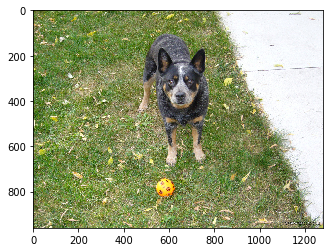

---------------------------
---------------------------
This is a Poodle dog.


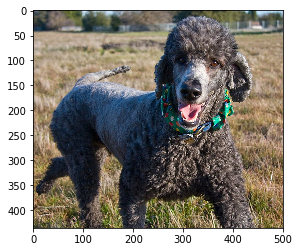

---------------------------
---------------------------
This looks like a human.


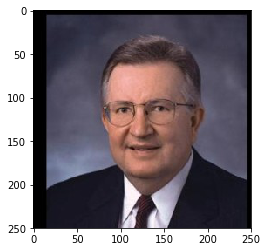

---------------------------
---------------------------
This looks like a human.


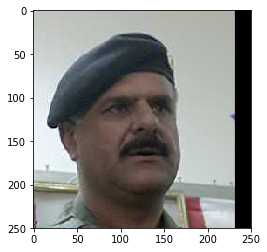

---------------------------
---------------------------
This looks like a human.


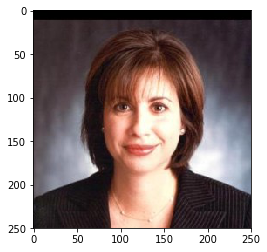

---------------------------
---------------------------
This is a Belgian sheepdog dog.


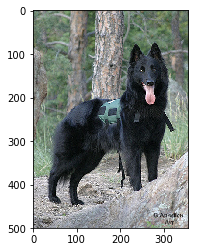

---------------------------
---------------------------
This is a Boston terrier dog.


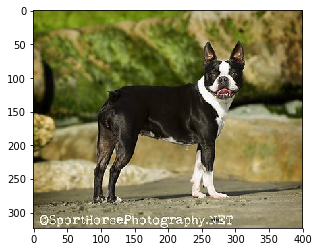

---------------------------


In [57]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in test_files:
    run_app(file)